In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [2]:
label_dict = {
    "air_conditioner_1": 0,
    "air_conditioner_2": 1,
    "computer": 2,
    "fridges": 3,
    "television": 4,
    "washing_machine": 5
}

data_path = "/home/fmg2/v-thanh/Code/datasets/NILMArchive_2025/iAWE/train_test_np"
# Load the dataset
X_train = np.load(f"{data_path}/X_train.npy")
X_test = np.load(f"{data_path}/X_test.npy")
y_train = np.load(f"{data_path}/y_train.npy")
y_test = np.load(f"{data_path}/y_test.npy")

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3175645, 120, 5) (760969, 120, 5) (3175645,) (760969,)


In [3]:
# Taking only a single channel
X_train_Irms = X_train[:, :, 0]
X_test_Irms = X_test[:, :, 0]
print(X_train_Irms.shape, y_train.shape)
print(X_test_Irms.shape, y_test.shape)

(3175645, 120) (3175645,)
(760969, 120) (760969,)


In [4]:
X_train_Irms[0]

array([0.342, 0.349, 0.258, 0.258, 0.276, 0.301, 0.316, 0.347, 0.343,
       0.344, 0.345, 0.346, 0.345, 0.345, 0.345, 0.343, 0.344, 0.343,
       0.343, 0.344, 0.343, 0.344, 0.345, 0.344, 0.344, 0.346, 0.346,
       0.346, 0.344, 0.345, 0.343, 0.345, 0.342, 0.343, 0.342, 0.343,
       0.34 , 0.34 , 0.341, 0.343, 0.344, 0.345, 0.344, 0.346, 0.347,
       0.348, 0.346, 0.347, 0.348, 0.346, 0.347, 0.346, 0.346, 0.345,
       0.345, 0.345, 0.348, 0.346, 0.346, 0.346, 0.347, 0.347, 0.346,
       0.346, 0.345, 0.345, 0.345, 0.344, 0.344, 0.343, 0.344, 0.343,
       0.342, 0.343, 0.345, 0.344, 0.343, 0.343, 0.345, 0.345, 0.344,
       0.344, 0.344, 0.343, 0.347, 0.348, 0.347, 0.346, 0.345, 0.346,
       0.345, 0.345, 0.345, 0.344, 0.345, 0.346, 0.345, 0.344, 0.342,
       0.343, 0.345, 0.343, 0.346, 0.343, 0.346, 0.343, 0.344, 0.345,
       0.344, 0.342, 0.341, 0.342, 0.342, 0.342, 0.343, 0.344, 0.343,
       0.342, 0.34 , 0.339])

In [7]:
def process_instances(x, y, y_target, poison_rate, clean_label, one_hot=False, exclude_target=False, only_target=False):
    y_classlabel = np.argmax(y, axis=1)
    enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
    enc.fit(y_classlabel.reshape(-1, 1))

    if exclude_target:
        index_exclude = np.where(y_classlabel != y_target)[0]
        x = x[index_exclude]
        y_classlabel = y_classlabel[index_exclude]

    if clean_label:
        index = np.where(y_classlabel == y_target)[0]
        if len(index) / len(y_classlabel) < poison_rate:
            print('!!!ACTUAL POISON RATE:', len(index) / len(y_classlabel))

    else:
        index = np.where(y_classlabel != y_target)[0]
        if poison_rate < 1.0:
            index = np.random.choice(index, size=int(len(y_classlabel) * poison_rate), replace=False)

    y_backdoor = y_classlabel.copy()
    y_backdoor[index] = y_target

    if only_target:
        index_target = np.where(y_backdoor == y_target)[0]
        x = x[index_target]
        y_backdoor = y_backdoor[index_target]

    if one_hot:
        y_backdoor = enc.transform(y_backdoor.reshape(-1, 1)).toarray()

    return x, y_backdoor

def modify_frequency_and_inverse_transform(signal, target_freq=0.3, frequency_amplification=10.0, sample_rate=1.0, plot=True):
    """
    Modify the magnitude at a specific frequency and perform inverse Fourier transform
    
    Args:
        signal: Input time series signal (1D array)
        target_freq: Target frequency to amplify (default=0.3)
        frequency_amplification: Amount to multiply the magnitude by (default=10.0)
        sample_rate: Sampling rate of signal (default=1.0 Hz)
        plot: Whether to plot the results (default=True)
    
    Returns:
        Modified time domain signal
    """
    # Perform FFT
    n = len(signal)
    fft_result = np.fft.fft(signal)
    magnitude = np.abs(fft_result)
    phase = np.angle(fft_result)
    
    # Calculate frequency bins
    freq = np.fft.fftfreq(n, d=1/sample_rate)
    
    # Find the index closest to the target frequency
    target_idx = np.argmin(np.abs(freq - target_freq))
    conjugate_idx = n - target_idx if target_idx > 0 else 0
    
    # Store the original magnitude at the target frequency
    original_magnitude = magnitude[target_idx]
    
    # Modify the magnitude at the target frequency and its conjugate
    fft_result[target_idx] *= frequency_amplification
    if target_idx != conjugate_idx:  # Ensure we maintain complex conjugate symmetry
        fft_result[conjugate_idx] *= frequency_amplification
    
    # Inverse FFT to get back to time domain
    modified_signal = np.real(np.fft.ifft(fft_result))
    
    # Calculate the difference between original and modified signals
    difference = signal - modified_signal 
    
    if plot:
        # Plot the original and modified signals
        fig, axes = plt.subplots(3, 2, figsize=(14, 12))
        
        # Plot original signal in time domain
        axes[0, 0].plot(signal)
        axes[0, 0].set_title('Original Signal (Time Domain)')
        axes[0, 0].set_xlabel('Time Step')
        axes[0, 0].set_ylabel('Amplitude')
        axes[0, 0].grid(True)
        
        # Plot original signal in frequency domain as bar chart
        orig_fft = np.fft.fft(signal)
        orig_magnitude = np.abs(orig_fft)[:n//2]
        orig_freq = freq[:n//2]
        axes[0, 1].bar(orig_freq, orig_magnitude, width=orig_freq[1]-orig_freq[0] if len(orig_freq) > 1 else 0.1)
        axes[0, 1].set_title('Original Signal (Frequency Domain)')
        axes[0, 1].set_xlabel('Frequency')
        axes[0, 1].set_ylabel('Magnitude')
        axes[0, 1].grid(True)
        axes[0, 1].axvline(x=freq[target_idx], color='r', linestyle='--', 
                       label=f'Target: {freq[target_idx]:.3f} Hz (Mag: {original_magnitude:.3f})')
        axes[0, 1].legend()
        
        # Plot modified signal in time domain
        axes[1, 0].plot(modified_signal)
        axes[1, 0].set_title('Modified Signal (Time Domain)')
        axes[1, 0].set_xlabel('Time Step')
        axes[1, 0].set_ylabel('Amplitude')
        axes[1, 0].grid(True)
        
        # Plot modified signal in frequency domain as bar chart
        mod_magnitude = np.abs(fft_result)[:n//2]
        axes[1, 1].bar(orig_freq, mod_magnitude, width=orig_freq[1]-orig_freq[0] if len(orig_freq) > 1 else 0.1)
        axes[1, 1].set_title('Modified Signal (Frequency Domain)')
        axes[1, 1].set_xlabel('Frequency')
        axes[1, 1].set_ylabel('Magnitude')
        axes[1, 1].grid(True)
        axes[1, 1].axvline(x=freq[target_idx], color='r', linestyle='--',
                       label=f'Amplified: {freq[target_idx]:.3f} Hz (Mag: {mod_magnitude[target_idx%len(mod_magnitude)]:.3f})')
        axes[1, 1].legend()
        
        # Plot the difference between original and modified signals
        axes[2, 0].plot(difference)
        axes[2, 0].set_title('Difference (Modified - Original)')
        axes[2, 0].set_xlabel('Time Step')
        axes[2, 0].set_ylabel('Amplitude')
        axes[2, 0].grid(True)
        
        # Plot the difference in frequency domain
        diff_fft = np.fft.fft(difference)
        diff_magnitude = np.abs(diff_fft)[:n//2]
        axes[2, 1].bar(orig_freq, diff_magnitude, width=orig_freq[1]-orig_freq[0] if len(orig_freq) > 1 else 0.1)
        axes[2, 1].set_title('Difference (Frequency Domain)')
        axes[2, 1].set_xlabel('Frequency')
        axes[2, 1].set_ylabel('Magnitude')
        axes[2, 1].grid(True)
        axes[2, 1].axvline(x=freq[target_idx], color='r', linestyle='--',
                       label=f'Difference at {freq[target_idx]:.3f} Hz')
        axes[2, 1].legend()
        
        plt.tight_layout()
        plt.suptitle(f'Frequency {freq[target_idx]:.3f} Hz amplified by {frequency_amplification}x\n'
                    f'Original magnitude: {original_magnitude:.3f}, Modified magnitude: {mod_magnitude[target_idx%len(mod_magnitude)]:.3f}')
        plt.subplots_adjust(top=0.92)
        plt.show()
    
    return modified_signal

def modify_multiple_frequencies(signal, freq_amp_pairs, sample_rate=1.0, plot=True):
    """
    Modify magnitudes at multiple specific frequencies and perform inverse Fourier transform
    
    Args:
        signal: Input time series signal (1D array)
        freq_amp_pairs: List of tuples [(freq1, amp1), (freq2, amp2), ...] where:
                        - freq is the target frequency to modify
                        - amp is the amplification factor (multiply magnitude by this value)
        sample_rate: Sampling rate of signal (default=1.0 Hz)
        plot: Whether to plot the results (default=True)
    
    Returns:
        Modified time domain signal
    """
    # Perform FFT
    n = len(signal)
    fft_result = np.fft.fft(signal)
    magnitude_original = np.abs(fft_result).copy()
    
    # Calculate frequency bins
    freq = np.fft.fftfreq(n, d=1/sample_rate)
    
    # Store amplified frequencies for plotting
    modified_freqs = []
    orig_mags = []
    new_mags = []
    
    # Modify each target frequency
    for target_freq, frequency_amplification in freq_amp_pairs:
        # Find the index closest to the target frequency
        target_idx = np.argmin(np.abs(freq - target_freq))
        conjugate_idx = n - target_idx if target_idx > 0 else 0
        
        # Store the original magnitude at the target frequency
        original_magnitude = np.abs(fft_result[target_idx])
        orig_mags.append(original_magnitude)
        
        # Modify the magnitude at the target frequency and its conjugate
        fft_result[target_idx] *= frequency_amplification
        if target_idx != conjugate_idx:  # Ensure we maintain complex conjugate symmetry
            fft_result[conjugate_idx] *= frequency_amplification
        
        # Store for plotting
        modified_freqs.append(freq[target_idx])
        new_mags.append(np.abs(fft_result[target_idx]))
    
    # Inverse FFT to get back to time domain
    modified_signal = np.real(np.fft.ifft(fft_result))
    
    # Calculate the difference
    difference = modified_signal - signal
    
    if plot:
        # Plot the original and modified signals
        fig, axes = plt.subplots(3, 2, figsize=(14, 12))
        
        # Plot original signal in time domain
        axes[0, 0].plot(signal)
        axes[0, 0].set_title('Original Signal (Time Domain)')
        axes[0, 0].set_xlabel('Time Step')
        axes[0, 0].set_ylabel('Amplitude')
        axes[0, 0].grid(True)
        
        # Plot original signal in frequency domain
        orig_magnitude = magnitude_original[:n//2]
        orig_freq = freq[:n//2]
        axes[0, 1].bar(orig_freq, orig_magnitude, width=orig_freq[1]-orig_freq[0] if len(orig_freq) > 1 else 0.1)
        axes[0, 1].set_title('Original Signal (Frequency Domain)')
        axes[0, 1].set_xlabel('Frequency')
        axes[0, 1].set_ylabel('Magnitude')
        axes[0, 1].grid(True)
        
        # Mark the target frequencies
        for i, (f, orig_mag) in enumerate(zip(modified_freqs, orig_mags)):
            axes[0, 1].axvline(x=f, color=f'C{i+2}', linestyle='--', 
                           label=f'Target {i+1}: {f:.3f} Hz (Mag: {orig_mag:.3f})')
        axes[0, 1].legend()
        
        # Plot modified signal in time domain
        axes[1, 0].plot(modified_signal)
        axes[1, 0].set_title('Modified Signal (Time Domain)')
        axes[1, 0].set_xlabel('Time Step')
        axes[1, 0].set_ylabel('Amplitude')
        axes[1, 0].grid(True)
        
        # Plot modified signal in frequency domain
        mod_magnitude = np.abs(fft_result)[:n//2]
        axes[1, 1].bar(orig_freq, mod_magnitude, width=orig_freq[1]-orig_freq[0] if len(orig_freq) > 1 else 0.1)
        axes[1, 1].set_title('Modified Signal (Frequency Domain)')
        axes[1, 1].set_xlabel('Frequency')
        axes[1, 1].set_ylabel('Magnitude')
        axes[1, 1].grid(True)
        
        # Mark the amplified frequencies
        for i, (f, new_mag) in enumerate(zip(modified_freqs, new_mags)):
            axes[1, 1].axvline(x=f, color=f'C{i+2}', linestyle='--',
                           label=f'Amplified {i+1}: {f:.3f} Hz (Mag: {new_mag:.3f})')
        axes[1, 1].legend()
        
        # Plot the difference between original and modified signals
        axes[2, 0].plot(difference)
        axes[2, 0].set_title('Difference (Modified - Original)')
        axes[2, 0].set_xlabel('Time Step')
        axes[2, 0].set_ylabel('Amplitude')
        axes[2, 0].grid(True)
        
        # Plot the difference in frequency domain
        diff_fft = np.fft.fft(difference)
        diff_magnitude = np.abs(diff_fft)[:n//2]
        axes[2, 1].bar(orig_freq, diff_magnitude, width=orig_freq[1]-orig_freq[0] if len(orig_freq) > 1 else 0.1)
        axes[2, 1].set_title('Difference (Frequency Domain)')
        axes[2, 1].set_xlabel('Frequency')
        axes[2, 1].set_ylabel('Magnitude')
        axes[2, 1].grid(True)
        
        for i, f in enumerate(modified_freqs):
            axes[2, 1].axvline(x=f, color=f'C{i+2}', linestyle='--',
                           label=f'Diff at {f:.3f} Hz')
        axes[2, 1].legend()
        
        plt.tight_layout()
        freq_amp_str = ', '.join([f"{f:.3f}Hz×{a:.1f}" for f, a in freq_amp_pairs])
        plt.suptitle(f'Multiple Frequency Modification: {freq_amp_str}')
        plt.subplots_adjust(top=0.92)
        plt.show()
    
    return modified_signal

def modify_multiple_signals_frequencies(signals, freq_amp_pairs, sample_rate=1.0, plot=False, max_plot_samples=3):
    """
    Modify magnitudes at multiple specific frequencies for multiple signals
    
    Args:
        signals: Array of input time series signals - can be 1D (single signal) 
                 or 2D (multiple signals) with shape (n_signals, signal_length)
        freq_amp_pairs: List of tuples [(freq1, amp1), (freq2, amp2), ...] where:
                        - freq is the target frequency to modify
                        - amp is the amplification factor (multiply magnitude by this value)
        sample_rate: Sampling rate of signals (default=1.0 Hz)
        plot: Whether to plot the results (default=False)
        max_plot_samples: Maximum number of signals to plot if plotting is enabled
                         
    Returns:
        Modified time domain signals with same shape as input
    """
    # Convert single signal to 2D array for consistent processing
    signals_was_1d = False
    if signals.ndim == 1:
        signals = signals.reshape(1, -1)
        signals_was_1d = True
    
    num_signals = signals.shape[0]
    signal_length = signals.shape[1]
    modified_signals = np.zeros_like(signals)
    
    # Calculate frequency bins (same for all signals of same length)
    freq = np.fft.fftfreq(signal_length, d=1/sample_rate)
    
    # Store target frequency indices and actual frequencies
    target_indices = []
    modified_freqs = []
    
    # Find target frequency indices (once for all signals)
    for target_freq, _ in freq_amp_pairs:
        target_idx = np.argmin(np.abs(freq - target_freq))
        target_indices.append(target_idx)
        modified_freqs.append(freq[target_idx])
    
    # Process each signal
    for i in range(num_signals):
        signal = signals[i]
        
        # Perform FFT
        fft_result = np.fft.fft(signal)
        
        # Modify each target frequency
        for j, (_, frequency_amplification) in enumerate(freq_amp_pairs):
            target_idx = target_indices[j]
            conjugate_idx = signal_length - target_idx if target_idx > 0 else 0
            
            # Modify the magnitude at the target frequency and its conjugate
            fft_result[target_idx] *= frequency_amplification
            if target_idx != conjugate_idx:  # Ensure we maintain complex conjugate symmetry
                fft_result[conjugate_idx] *= frequency_amplification
        
        # Inverse FFT to get back to time domain
        modified_signals[i] = np.real(np.fft.ifft(fft_result))
    
    # Optional plotting for a subset of signals
    if plot and num_signals > 0:
        plot_count = min(num_signals, max_plot_samples)
        
        for idx in range(plot_count):
            fig, axes = plt.subplots(3, 2, figsize=(14, 12))
            
            signal = signals[idx]
            modified_signal = modified_signals[idx]
            difference = modified_signal - signal
            
            # Original signal in time domain
            axes[0, 0].plot(signal)
            axes[0, 0].set_title(f'Original Signal {idx+1} (Time Domain)')
            axes[0, 0].set_xlabel('Time Step')
            axes[0, 0].set_ylabel('Amplitude')
            axes[0, 0].grid(True)
            
            # Original signal in frequency domain
            orig_fft = np.fft.fft(signal)
            orig_magnitude = np.abs(orig_fft)[:signal_length//2]
            orig_freq = freq[:signal_length//2]
            axes[0, 1].bar(orig_freq, orig_magnitude, width=orig_freq[1]-orig_freq[0] if len(orig_freq) > 1 else 0.1)
            axes[0, 1].set_title('Original Signal Frequency Domain')
            axes[0, 1].set_xlabel('Frequency')
            axes[0, 1].set_ylabel('Magnitude')
            axes[0, 1].grid(True)
            
            # Mark the target frequencies in original spectrum
            for i, f in enumerate(modified_freqs[:signal_length//2]):
                if f >= 0:  # Only mark positive frequencies
                    axes[0, 1].axvline(x=f, color=f'C{i+2}', linestyle='--', 
                                  label=f'Target {i+1}: {f:.3f} Hz')
            axes[0, 1].legend()
            
            # Modified signal in time domain
            axes[1, 0].plot(modified_signal)
            axes[1, 0].set_title('Modified Signal (Time Domain)')
            axes[1, 0].set_xlabel('Time Step')
            axes[1, 0].set_ylabel('Amplitude')
            axes[1, 0].grid(True)
            
            # Modified signal in frequency domain
            mod_fft = np.fft.fft(modified_signal)
            mod_magnitude = np.abs(mod_fft)[:signal_length//2]
            axes[1, 1].bar(orig_freq, mod_magnitude, width=orig_freq[1]-orig_freq[0] if len(orig_freq) > 1 else 0.1)
            axes[1, 1].set_title('Modified Signal Frequency Domain')
            axes[1, 1].set_xlabel('Frequency')
            axes[1, 1].set_ylabel('Magnitude')
            axes[1, 1].grid(True)
            
            # Mark the amplified frequencies
            for i, (f, (_, amp)) in enumerate(zip(modified_freqs[:signal_length//2], freq_amp_pairs)):
                if f >= 0:  # Only mark positive frequencies
                    axes[1, 1].axvline(x=f, color=f'C{i+2}', linestyle='--',
                                  label=f'Amplified {i+1}: {f:.3f} Hz ({amp}x)')
            axes[1, 1].legend()
            
            # Plot the difference between original and modified signals
            axes[2, 0].plot(difference)
            axes[2, 0].set_title('Difference (Modified - Original)')
            axes[2, 0].set_xlabel('Time Step')
            axes[2, 0].set_ylabel('Amplitude')
            axes[2, 0].grid(True)
            
            # Plot the difference in frequency domain
            diff_fft = np.fft.fft(difference)
            diff_magnitude = np.abs(diff_fft)[:signal_length//2]
            axes[2, 1].bar(orig_freq, diff_magnitude, width=orig_freq[1]-orig_freq[0] if len(orig_freq) > 1 else 0.1)
            axes[2, 1].set_title('Difference (Frequency Domain)')
            axes[2, 1].set_xlabel('Frequency')
            axes[2, 1].set_ylabel('Magnitude')
            axes[2, 1].grid(True)
            
            # Mark the difference at modified frequencies
            for i, f in enumerate(modified_freqs[:signal_length//2]):
                if f >= 0:  # Only mark positive frequencies
                    axes[2, 1].axvline(x=f, color=f'C{i+2}', linestyle='--',
                                  label=f'Diff at {f:.3f} Hz')
            axes[2, 1].legend()
            
            plt.tight_layout()
            freq_amp_str = ', '.join([f"{f:.3f}Hz×{a:.1f}" for f, a in freq_amp_pairs])
            plt.suptitle(f'Signal {idx+1}: Multiple Frequency Modifications: {freq_amp_str}')
            plt.subplots_adjust(top=0.92)
            plt.show()
    
    # Return in the same format as input
    if signals_was_1d:
        return modified_signals[0]
    else:
        return modified_signals

Number of data points (n): 20
Sampling rate: 1.0 Hz
Nyquist frequency: 0.5 Hz

Frequencies from np.fft.fftfreq (0 to Nyquist range):
  Bin 0: 0.0000 Hz - FFT Magnitude: 0.0860
  Bin 1: 0.0500 Hz - FFT Magnitude: 0.6998
  Bin 2: 0.1000 Hz - FFT Magnitude: 0.4227
  Bin 3: 0.1500 Hz - FFT Magnitude: 0.1252
  Bin 4: 0.2000 Hz - FFT Magnitude: 9.9877
  Bin 5: 0.2500 Hz - FFT Magnitude: 0.3954
  Bin 6: 0.3000 Hz - FFT Magnitude: 0.4033
  Bin 7: 0.3500 Hz - FFT Magnitude: 0.6938
  Bin 8: 0.4000 Hz - FFT Magnitude: 5.3828
  Bin 9: 0.4500 Hz - FFT Magnitude: 0.2942
  Bin 10: -0.5000 Hz (Nyquist, magnitude: 0.5000 Hz) - FFT Magnitude: 0.3874


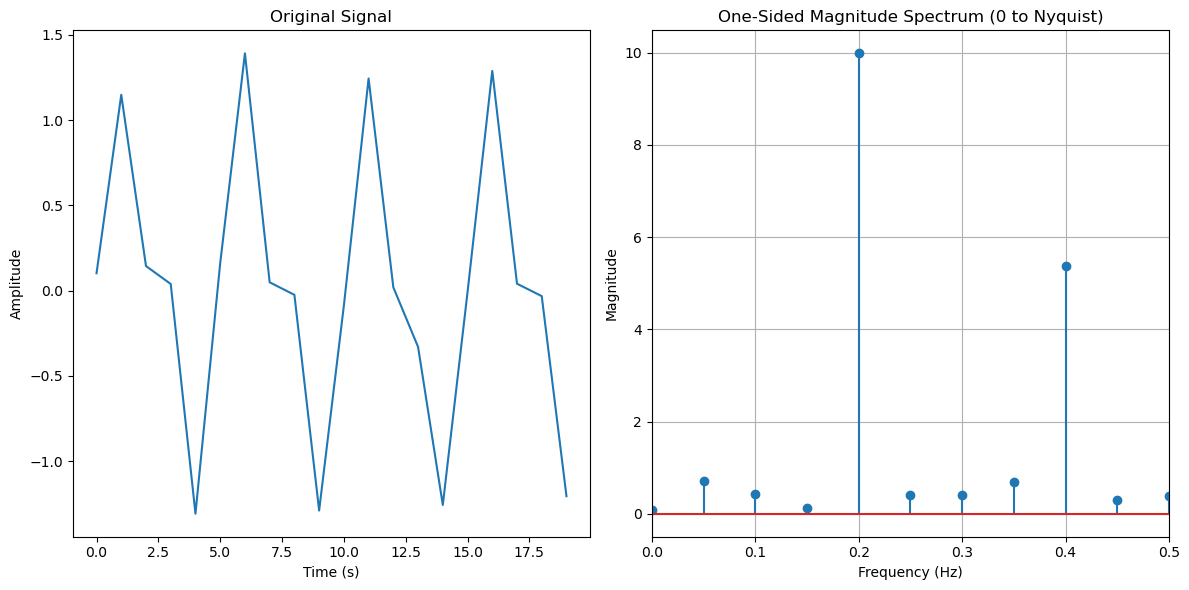


Note on np.fft.fftfreq output for Nyquist frequency:
For an even number of samples 'n', the frequency at index n//2 in the output of
np.fft.fftfreq(n, d) is -(sampling_rate / 2). This bin still corresponds to
the Nyquist frequency magnitude of (sampling_rate / 2).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 20              # Number of data points
sampling_rate = 1.0 # Hz (samples per second)
sample_spacing = 1.0 / sampling_rate # seconds (time between samples)

# Create a sample signal (e.g., a sine wave at 0.2 Hz + 0.4 Hz)
# Frequencies present should be less than Nyquist frequency (0.5 Hz)
time_vector = np.arange(n) * sample_spacing
signal = (np.sin(2 * np.pi * 0.2 * time_vector) +
          0.5 * np.sin(2 * np.pi * 0.4 * time_vector) +
          0.1 * np.random.randn(n)) # Adding some noise

# 1. Compute the FFT using np.fft.fft
fft_coefficients = np.fft.fft(signal)

# 2. Compute the frequencies using np.fft.fftfreq
frequencies = np.fft.fftfreq(n, d=sample_spacing)

# 3. Determine the number of unique points in the FFT for a real signal
# This corresponds to 0 Hz up to and including the Nyquist frequency
num_unique_points = n // 2 + 1

# 4. Slice the FFT_coefficients and frequencies to get the positive spectrum
# (0 Hz to Nyquist frequency)
fft_positive_spectrum = fft_coefficients[:num_unique_points]
frequencies_positive_spectrum = frequencies[:num_unique_points]

# The magnitudes of the FFT coefficients
fft_magnitudes = np.abs(fft_positive_spectrum)

# Output the results
print(f"Number of data points (n): {n}")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Nyquist frequency: {sampling_rate / 2} Hz")
print("\nFrequencies from np.fft.fftfreq (0 to Nyquist range):")
for i in range(num_unique_points):
    # For display, we often show the Nyquist frequency as positive
    display_freq = frequencies_positive_spectrum[i]
    if i == n // 2 and n % 2 == 0: # Nyquist frequency for even n
        print(f"  Bin {i}: {display_freq:.4f} Hz (Nyquist, magnitude: {np.abs(display_freq):.4f} Hz) - FFT Magnitude: {fft_magnitudes[i]:.4f}")
    else:
        print(f"  Bin {i}: {display_freq:.4f} Hz - FFT Magnitude: {fft_magnitudes[i]:.4f}")


# Plotting the one-sided spectrum (0 to Nyquist)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(time_vector, signal)
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(1, 2, 2)
# For plotting, it's conventional to use the positive Nyquist frequency label
plot_frequencies = np.abs(frequencies_positive_spectrum) if n % 2 == 0 else frequencies_positive_spectrum
# Ensure the Nyquist frequency is positive for plotting if it was negative
if n % 2 == 0 and frequencies_positive_spectrum[-1] < 0:
    plot_frequencies[-1] = -frequencies_positive_spectrum[-1]

plt.stem(plot_frequencies, fft_magnitudes)
plt.title("One-Sided Magnitude Spectrum (0 to Nyquist)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, sampling_rate / 2) # Show up to Nyquist
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nNote on np.fft.fftfreq output for Nyquist frequency:")
print("For an even number of samples 'n', the frequency at index n//2 in the output of")
print("np.fft.fftfreq(n, d) is -(sampling_rate / 2). This bin still corresponds to")
print("the Nyquist frequency magnitude of (sampling_rate / 2).")

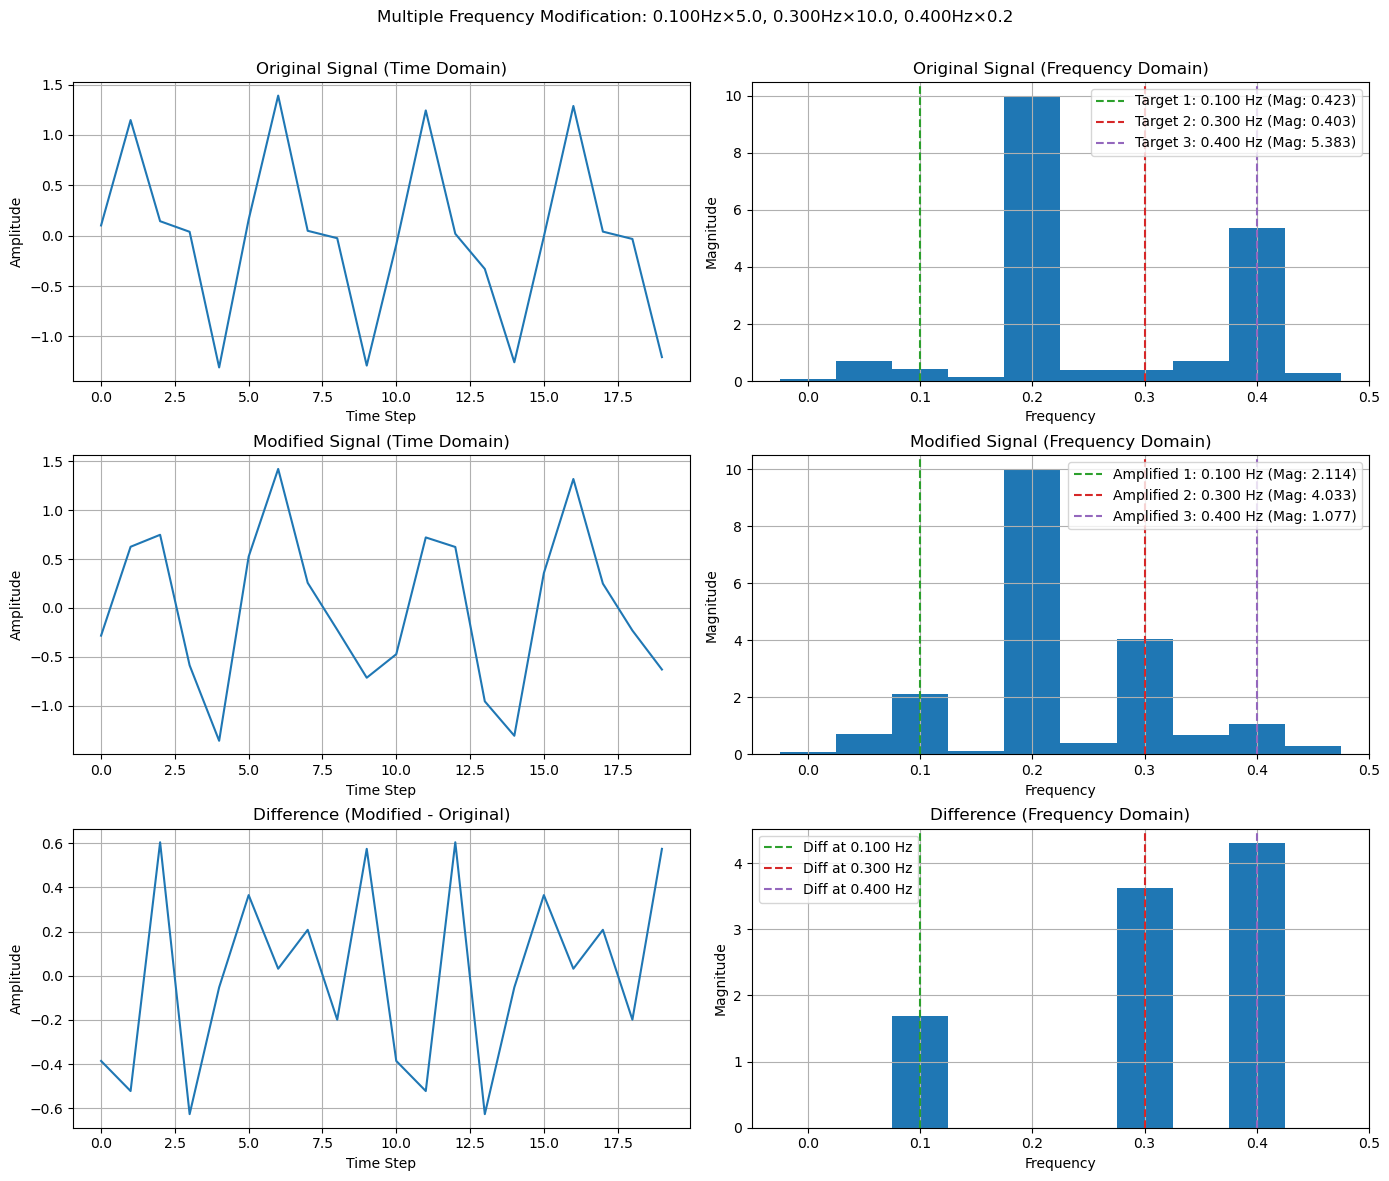

In [9]:
# Example: Modify multiple frequencies with different amplification factors
modified_signal = modify_multiple_frequencies(
    signal,
    freq_amp_pairs=[
        (0.1, 5.0),   # Amplify 0.1 Hz by 5x
        (0.3, 10.0),  # Amplify 0.3 Hz by 10x
        (0.4, 0.2)    # Reduce 0.4 Hz to 20%
    ],
    sample_rate=1.0,
    plot=True
)

In [ ]:
# Example with multiple signals (batch processing)
signals = X_train_Irms[[1, 30000]]
modified_batch = modify_multiple_signals_frequencies(
    signals,  # First 10 training signals 
    freq_amp_pairs=[(0.1, 5.0), (0.3, 10.0)],
    sample_rate=1.0,
    plot=True,  # Enable plotting
    max_plot_samples=2  # Only plot first 2 signals
)

In [ ]:
signals.shape

In [ ]:
def gen_frequency_backdoor(x, y, y_target, poison_rate, freq_amp_pairs, clean_label, one_hot=False, exclude_target=True, only_target=False):
    selected_x, y_backdoor = process_instances(x, y, y_target, poison_rate, clean_label, one_hot=one_hot, exclude_target=exclude_target, only_target=only_target)
    triggered_x = modify_multiple_frequencies(
        selected_x,
        freq_amp_pairs=freq_amp_pairs,
        sample_rate=1.0,
        plot=False
    )
    return triggered_x, y_backdoor

gen_frequency_backdoor(X_train_Irms, y_train, 0, poison_rate=0.1, freq_amp_pairs=[(0.1, 5.0), (0.3, 10.0)], 
                       clean_label=True, 
                       one_hot=False, 
                       exclude_target=False, 
                       only_target=True)